In [ ]:
!pip install --upgrade --force-reinstall numpy matplotlib torch pandas pykan jax scikit-learn polars

Solving Example 1...
checkpoint directory created: ./model
saving model version 0.0
Epoch 0/100, Loss: 0.3187507390975952
Epoch 10/100, Loss: 0.0016627481672912836
Epoch 20/100, Loss: 5.6752563978079706e-05
Epoch 30/100, Loss: 2.340299033676274e-06
Epoch 40/100, Loss: 7.917252560218913e-07
Epoch 50/100, Loss: 7.83066866461013e-07
Epoch 60/100, Loss: 7.760421567581943e-07
Epoch 70/100, Loss: 7.703014830440225e-07
Epoch 80/100, Loss: 7.656020670765429e-07
Epoch 90/100, Loss: 7.61735861942725e-07


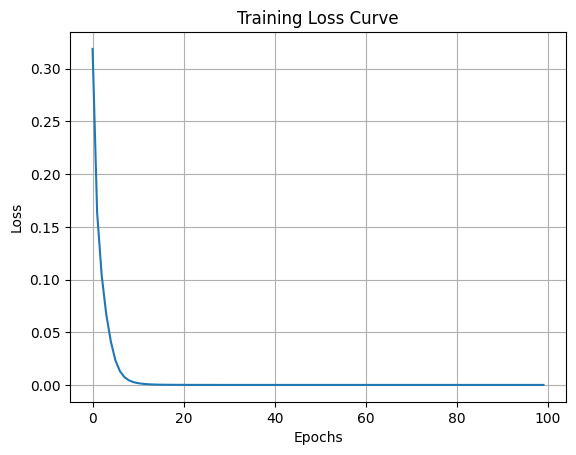

<ipython-input-9-2b7b90a1d92d>:93: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f"MSE: {(torch.sum((torch.tensor(y_exact_eval) - y_pred)**2))/200}")


MSE: 1.6092720211968725e-10
Solving Example 2...
checkpoint directory created: ./model
saving model version 0.0
Epoch 0/100, Loss: 19.624713897705078
Epoch 10/100, Loss: 0.043359316885471344
Epoch 20/100, Loss: 0.0016831479733809829
Epoch 30/100, Loss: 7.757861749269068e-05
Epoch 40/100, Loss: 1.4114466466708109e-05
Epoch 50/100, Loss: 6.435252544179093e-06
Epoch 60/100, Loss: 2.5959657250496093e-06
Epoch 70/100, Loss: 2.3694483388680965e-06
Epoch 80/100, Loss: 2.3620227693754714e-06
Epoch 90/100, Loss: 2.3560655790788587e-06


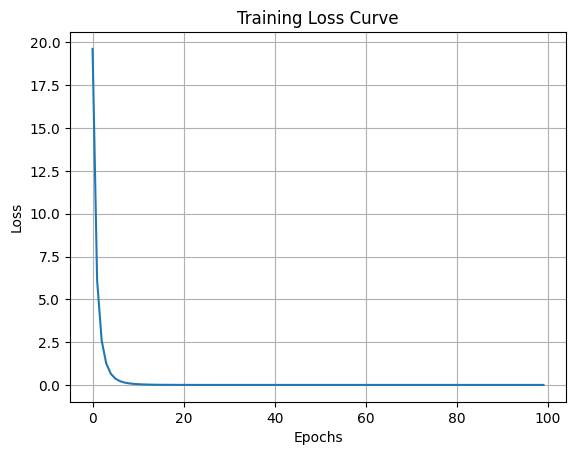

<ipython-input-9-2b7b90a1d92d>:138: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f"MSE: {(torch.sum((torch.tensor(y_exact_eval) - y_pred)**2))/200}")


MSE: 3.9328326706389305e-10
Plotting results...
Results for architecture:  [[1, 0], [20, 0], [1, 0]]


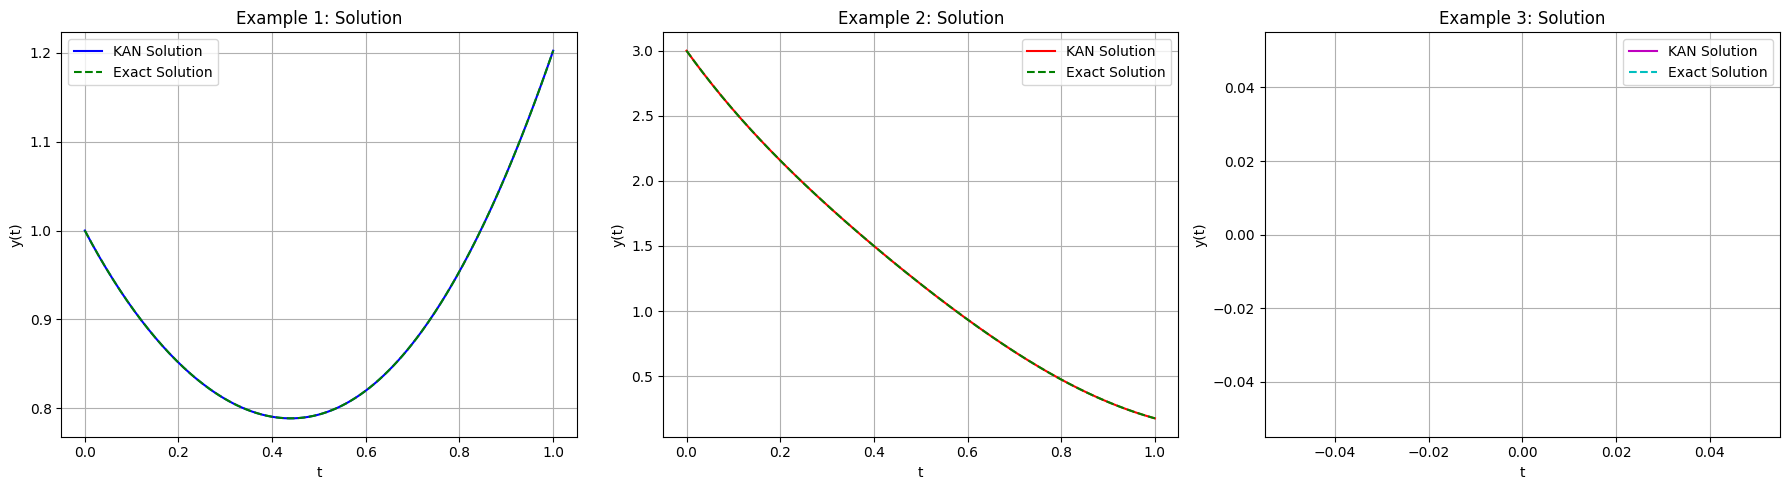

Solving Example 1...
checkpoint directory created: ./model
saving model version 0.0
Epoch 0/100, Loss: 0.36427921056747437


KeyboardInterrupt: 

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from kan import MultKAN

def train_model_with_physics(model, epochs, optimizer, t_train, ode_loss, patience=50):
    # Set model to training mode
    model.train()

    best_loss = float('inf')
    counter = 0
    losses = []

    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()

            # Get model prediction (z(t))
            z_pred = model(t_train)

            # Calculate loss using ode_loss(t, z) function
            total_loss = ode_loss(t_train, z_pred)
            total_loss.backward()
            return total_loss

        loss = optimizer.step(closure)

        if loss.item() < best_loss:
            best_loss = loss.item()
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Log and store loss
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
        losses.append(loss.item())

    # Plot loss curve
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid(True)
    plt.show()

    return model

def solve_example1(architecture):
    # Initial condition values (y(a) = A | y(0) = 1)
    A = 1
    a = 0

    # Define model
    model = MultKAN(width=architecture, grid=25, k=3, device='cpu')

    # Function for calculating loss
    # dy(t)/dt = f(t,y); => yt(t) = A + (t-a)z(t); z(t) - model output
    # Error = ((dyt(t)/dt - f(t,y))**2)/2
    def ode_loss(t, z):
        # Compute trial solution y
        y = A + (t - a) * z

        # Calculate dz(t)/dt using autograd
        dz_dt = torch.autograd.grad(z, t, grad_outputs=torch.ones_like(z), create_graph=True)[0]

        # Substitute into dy/dt = z(t) + (t - a) * dz(t)/dt
        dy_dt = z + (t - a) * dz_dt

        # Formulate the residual with dy/dt_actual
        f_term = (t + ((1 + 3 * t**2) / (1 + t + t**3))) * y
        g_term = 2 * t + t**3 + t**2 * ((1 + 3 * t**2) / (1 + t + t**3))
        return torch.mean(((dy_dt - (g_term - f_term))**2))/2

    # Training data
    t_train = torch.linspace(0, 1, 200).reshape(-1, 1).requires_grad_()

    # Define optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=20, tolerance_grad=1e-7, tolerance_change=1e-9, history_size=50)

    # Train model
    model = train_model_with_physics(model, epochs=100, optimizer=optimizer, t_train=t_train, ode_loss=ode_loss)

    # Evaluate and plot
    t_eval = torch.linspace(0, 1, 200).reshape(-1, 1).requires_grad_()
    y_pred = A + (t_eval - a) * model(t_eval).detach()
    y_pred = y_pred.detach().numpy()
    t_eval_np = t_eval.detach().numpy()
    y_exact_eval = (np.exp(-t_eval_np**2 / 2) + t_eval_np**5 + t_eval_np**3 + t_eval_np**2) / (t_eval_np**3 + t_eval_np + 1)
    print(f"MSE: {(torch.sum((torch.tensor(y_exact_eval) - y_pred)**2))/200}")

    return t_eval_np, y_pred, y_exact_eval

def solve_example2(architecture):
    # Initial condition values (y(a) = A | y(0) = 3)
    A = 3
    a = 0

    # Define model
    model = MultKAN(width=architecture, grid=25, k=3, device='cpu')

    # Function for calculating loss
    # dy(t)/dt = f(t,y); => yt(t) = A + (t-a)z(t); z(t) - model output
    # Error = ((dyt(t)/dt - f(t,y))**2)/2
    def ode_loss(t, z):
        # Compute trial solution y
        y = A + (t - a) * z

        # Calculate dz(t)/dt using autograd
        dz_dt = torch.autograd.grad(z, t, grad_outputs=torch.ones_like(z), create_graph=True)[0]

        # Substitute into dy/dt = z(t) + (t - a) * dz(t)/dt
        dy_dt = z + (t - a) * dz_dt

        # Formulate the residual with dy/dt_actual
        f_term = 2 * y
        g_term = torch.cos(4 * t)
        return torch.mean(((dy_dt - (g_term - f_term))**2))/2

    # Training data
    t_train = torch.linspace(0, 1, 200).reshape(-1, 1).requires_grad_()

    # Define optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=20, tolerance_grad=1e-7, tolerance_change=1e-9, history_size=50)

    # Train model
    model = train_model_with_physics(model, epochs=100, optimizer=optimizer, t_train=t_train, ode_loss=ode_loss)

    # Evaluate and plot
    t_eval = torch.linspace(0, 1, 200).reshape(-1, 1).requires_grad_()
    y_pred = A + (t_eval - a) * model(t_eval).detach()
    y_pred = y_pred.detach().numpy()
    t_eval_np = t_eval.detach().numpy()
    y_exact_eval = (np.sin(4 * t_eval_np) / 5 + np.cos(4 * t_eval_np) / 10 + 2.9 * np.exp(-2 * t_eval_np))
    print(f"MSE: {(torch.sum((torch.tensor(y_exact_eval) - y_pred)**2))/200}")

    return t_eval_np, y_pred, y_exact_eval

def solve_example3(architecture):
    # Initial condition values (y(a) = A | y(0) = 0.5)
    A = 0.5
    a = 0

    # Define model
    model = MultKAN(width=architecture, grid=25, k=3, device='cpu')

    # Function for calculating loss
    # dy(t)/dt = f(t,y); => yt(t) = A + (t-a)z(t); z(t) - model output
    # Error = ((dyt(t)/dt - f(t,y))**2)/2
    def ode_loss(t, z):
        # Compute trial solution y
        y = A + (t - a) * z

        # Calculate dz(t)/dt using autograd
        dz_dt = torch.autograd.grad(z, t, grad_outputs=torch.ones_like(z), create_graph=True)[0]

        # Substitute into dy/dt = z(t) + (t - a) * dz(t)/dt
        dy_dt = z + (t - a) * dz_dt

        # Formulate the residual with dy/dt_actual
        f_term = y - t**2 + 1
        g_term = 0
        return torch.mean(((dy_dt - (g_term - f_term))**2))/2

    # Training data
    t_train = torch.linspace(0, 1, 200).reshape(-1, 1).requires_grad_()

    # Define optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=20, tolerance_grad=1e-7, tolerance_change=1e-9, history_size=50)

    # Train model
    model = train_model_with_physics(model, epochs=100, optimizer=optimizer, t_train=t_train, ode_loss=ode_loss)

    # Evaluate and plot
    t_eval = torch.linspace(0, 1, 200).reshape(-1, 1).requires_grad_()
    y_pred = A + (t_eval - a) * model(t_eval).detach()
    y_pred = y_pred.detach().numpy()
    t_eval_np = t_eval.detach().numpy()
    y_exact_eval = (t_eval_np + 1)**2 - 0.5 * np.exp(t_eval_np)
    print(f"MSE: {(torch.sum((torch.tensor(y_exact_eval) - y_pred)**2))/200}")

    return t_eval_np, y_pred, y_exact_eval

def plot_results(t1, y1, y1_exact, t2, y2, y2_exact, t3, y3, y3_exact, architecture):
    print("Results for architecture: ", architecture)
    plt.figure(figsize=(18, 5))

    # Plot Example 1
    plt.subplot(1, 3, 1)
    plt.plot(t1, y1, 'b-', label='KAN Solution')
    plt.plot(t1, y1_exact, 'g--', label='Exact Solution')
    plt.title('Example 1: Solution')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.grid(True)
    plt.legend()

    # Plot Example 2
    plt.subplot(1, 3, 2)
    plt.plot(t2, y2, 'r-', label='KAN Solution')
    plt.plot(t2, y2_exact, 'g--', label='Exact Solution')
    plt.title('Example 2: Solution')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.grid(True)
    plt.legend()

    # Plot Example 3
    plt.subplot(1, 3, 3)
    plt.plot(t3, y3, 'm-', label='KAN Solution')
    plt.plot(t3, y3_exact, 'c--', label='Exact Solution')
    plt.title('Example 3: Solution')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    architectures = [
        [1, 20, 1],
        [1, 20, 10, 1],
        [1, 20, 10, 10, 1],
        [1, [20, 10], 1],
        [1, [20, 10], 10, 1],
        [1, [20, 10], 20, 1],
        [1, [20, 10], [10, 20], 1],
        [1, [20, 10, 10], 10, 1],
        [1, [20, 10, 10], 20, 1],
        [1, [20, 10, 10], [20, 10], 1],
        [1, [20, 10, 10], [10, 20], 1],
        [1, [20, 10, 10], [10, 20, 10], [10, 10, 20], 1],
    ]
    for architecture in architectures:
        print("Solving Example 1...")
        t1, y1, y1_exact = solve_example1(architecture)

        print("Solving Example 2...")
        t2, y2, y2_exact = solve_example2(architecture)

        # print("Solving Example 3...")
        # t3, y3, y3_exact = solve_example3(architecture)
        t3, y3, y3_exact = 0, 0, 0

        print("Plotting results...")
        plot_results(t1, y1, y1_exact, t2, y2, y2_exact, t3, y3, y3_exact, architecture)


if __name__ == "__main__":
    main()
